## Homework 1

check prediction for rainy days only

In [62]:
import torch
from torch.utils.data import TensorDataset,DataLoader
import pytorch_forecasting
import numpy as np
import os
from scipy import stats

os.chdir(os.getcwd())
fieldname = '_19790101-20190228.npy'
x1_arr = np.load('z1000'+fieldname) # geopotential height data (9*9 resolution)
#x2_arr = x1_arr.copy() # geopotential height data (9*9 resolution)
x2_arr = np.load('pv300'+fieldname) # potential vorticity data (9*9 resolution)

x1_arr_norm = stats.zscore(x1_arr) # normalize
x2_arr_norm = stats.zscore(x2_arr)
y_arr = np.load('rain_basin_19790101-20190228.npy') # rain data

tensor_x = torch.Tensor(np.stack([x1_arr_norm,x2_arr_norm],axis=1)) # join z,z and pv data
tensor_y = torch.Tensor(y_arr)

forecast_dataset = TensorDataset(tensor_x,tensor_y) # creates a dataset based on tensors

train_size = int(np.ceil(0.8*len(forecast_dataset)))
train_set, val_set = torch.utils.data.random_split(forecast_dataset,[train_size,len(forecast_dataset)-train_size])

In [63]:
sum(np.any(y_arr>0.1,axis=1))/len(y_arr) # wet days

0.5140748838480459

In [64]:
training_dataloader = DataLoader(train_set,batch_size=300,shuffle=True)
valid_dataloader = DataLoader(val_set,batch_size=300)

In [65]:
tensor_x.shape
for x,y in training_dataloader:
    print(x.shape,y.shape)
    break

torch.Size([300, 2, 9, 9]) torch.Size([300, 4])


### activate autoreload so any changes you make to dataloader.py, model.py are automatically imported

In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
from model_NN import Net
import matplotlib.pyplot as plt

net = Net()

## the training:


In [68]:
import torch.nn as nn
import torch.optim as optim
import tqdm

loss_func = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.001) 

In [69]:
def compute_accuracy_and_loss(dataloader,net):
    total = 0
    correct = 0
    loss = 0
    
    if torch.cuda.is_available():
        net.cuda()
    net.eval()
    
    n_batches = 0
    with torch.no_grad():
        for x,y in dataloader:
            n_batches+=1
            
            if torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()
            pred = net(x)
            
            loss+= loss_func(pred,y).item()
            
            err_abs = torch.abs(y-pred)
            err_rel = err_abs/y
            correct_abs = err_abs<=1
            correct_rel = err_rel<=0.1
            
            # an accurate prediction is where all stations of a predicted day either have relative errors<10%
            # or absolute errors<1mm
            correct_batch = np.logical_or(correct_abs,correct_rel).all(axis=1)
            
            correct+=sum(correct_batch).item()
            total+=len(y)
            
    loss = loss/n_batches      
    return correct/total, loss

In [70]:
compute_accuracy_and_loss(training_dataloader,net)

(0.5771857923497268, 4.07939829826355)

In [71]:
compute_accuracy_and_loss(valid_dataloader,net)

(0.5581395348837209, 4.397224585215251)

In [72]:
if torch.cuda.is_available():
    net.cuda()

In [73]:
# for VGG

import torchvision.models as models

#pretrained_model = models.vgg11(pretrained=True)
#pretrained_dict = pretrained_model.state_dict()
#state_dict = net.state_dict()

#for key in state_dict.keys():
 #   if 'features' not in key:
  #      continue
#    if key in pretrained_dict.keys():
 #       state_dict[key] = pretrained_dict[key]

#net.load_state_dict(state_dict)

In [74]:

n_epochs = 50


training_loss_vs_epoch = []
validation_loss_vs_epoch = []

training_acc_vs_epoch = []
validation_acc_vs_epoch = []

pbar = tqdm.tqdm( range(n_epochs) )

for epoch in pbar:
    
    loss,correct,total = 0,0,0
    
    if len(validation_loss_vs_epoch) > 1:
        pbar.set_description('val acc:'+'{0:.5f}'.format(validation_acc_vs_epoch[-1])+
                             ', train acc:'+'{0:.5f}'.format(training_acc_vs_epoch[-1]))
    
    net.train() # put the net into "training mode"
    for x,y in training_dataloader:
        
        optimizer.zero_grad() # zero the gradient
        
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()

        pred = net(x)
        
        cur_lossfunc = loss_func(pred,y)
        loss+= cur_lossfunc.item()
        
        cur_lossfunc.backward()
        optimizer.step()
    net.eval() #put the net into evaluation mode
    
    
    train_acc, train_loss = compute_accuracy_and_loss(training_dataloader,net)
    valid_acc, valid_loss =  compute_accuracy_and_loss(valid_dataloader,net)
         
    training_loss_vs_epoch.append( train_loss)    
    training_acc_vs_epoch.append( train_acc )
    
    validation_acc_vs_epoch.append(valid_acc)
    
    validation_loss_vs_epoch.append(valid_loss)
    
    #save the model if the validation loss has decreased
#    if len(validation_loss_vs_epoch)==1 or validation_loss_vs_epoch[-2] > validation_loss_vs_epoch[-1]:
#        torch.save(net.state_dict(), 'trained_model.pt')

val acc:0.46922, train acc:0.57377: 100%|██████████| 50/50 [00:05<00:00,  9.85it/s]


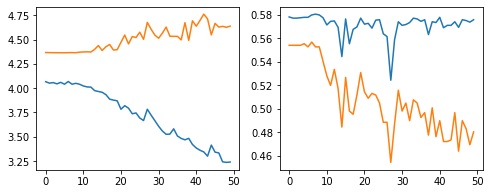

In [75]:
fig,ax = plt.subplots(1,2,figsize=(8,3))

ax[0].plot(training_loss_vs_epoch,label='training')
ax[0].plot(validation_loss_vs_epoch,label='validation')

ax[1].plot(training_acc_vs_epoch)
ax[1].plot(validation_acc_vs_epoch)

plt.show()